<a href="https://colab.research.google.com/github/jiin124/Dacon/blob/main/%ED%95%AD%EA%B3%B5%EC%82%AC%20%EA%B3%A0%EA%B0%9D%20%EB%A7%8C%EC%A1%B1%EB%8F%84%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%ED%95%AD%EA%B3%B5%EC%82%AC_%EA%B3%A0%EA%B0%9D_%EB%A7%8C%EC%A1%B1%EB%8F%84_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 각 Feature에 좀 더 신경써보자! 현재 점수 코드! [public : 0.938]


https://dacon.io/competitions/official/235871/codeshare/4521?page=1&dtype=recent

- pycarat
- 나잇대별 카테고리 만들기
- object 형식 onehotencoding
- 피쳐제거
- Et,lgbm,xgb,cat voting

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/airline_dataset/train.csv')
test=pd.read_csv('/content/drive/MyDrive/airline_dataset/test.csv')
sample=pd.read_csv('/content/drive/MyDrive/airline_dataset/sample_submission.csv')

## Feature Engineering

### Age to category

In [ ]:
def age_categorize(age):
  age=(age//10)*10
  return age

In [ ]:
#나이대별로 카테고리화
train['Age_cat']=train['Age'].apply(age_categorize).astype('category')
test['Age_cat']=test['Age'].apply(age_categorize).astype('category')

In [ ]:
train.drop('Age',axis=1,inplace=True)
test.drop('Age',axis=1,inplace=True)

### 출발지연, 도착지연

- 출발지연이 있으면 도착 지연이 있을 거라 생각했지만 긴 시간동안 출발지연이 된 경우만 해당하고 사소하게 딜레이된 것은 한쪽이 0일 수 있다.
- 그래서 두 피쳐의 평균만 사용할 것이다. 

In [ ]:
train['Delay']=(train['Departure Delay in Minutes']+train['Arrival Delay in Minutes'])/2
test['Delay']=(test['Departure Delay in Minutes']+test['Arrival Delay in Minutes'])/2

In [ ]:

train.drop(['Departure Delay in Minutes','Arrival Delay in Minutes'],axis=1,inplace=True)
test.drop(['Departure Delay in Minutes','Arrival Delay in Minutes'],axis=1,inplace=True)

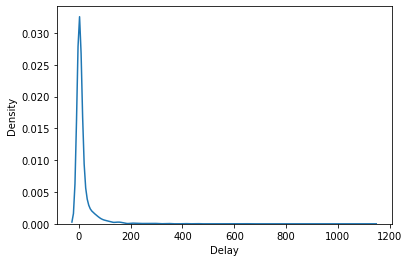

In [ ]:
sns.kdeplot(train['Delay'])

In [ ]:
train['Delay']=np.log1p(train['Delay'])
test['Delay']=np.log1p(test['Delay'])

### 0이 있는 이산형 feature

In [ ]:
zero_feat= ['Seat comfort', 'Food and drink', 'Inflight entertainment', 'Leg room service']

In [ ]:
#seat comfort
for feat in zero_feat:
  print(feat)
  print(train[feat][train['Seat comfort']==0].value_counts(),'\n')

Seat comfort
0    106
Name: Seat comfort, dtype: int64 

Food and drink
0    100
1      5
3      1
Name: Food and drink, dtype: int64 

Inflight entertainment
0    44
5    28
4    23
1     5
3     4
2     2
Name: Inflight entertainment, dtype: int64 

Leg room service
5    22
2    21
4    21
3    19
1    15
0     8
Name: Leg room service, dtype: int64 



seat comfort랑 food and drink 가 0이면 무조건 만족

In [ ]:
#Inflight entertainment
for feat in zero_feat:
  print(feat)
  print(train[feat][train['Inflight entertainment']==0].value_counts(),'\n')

Seat comfort
0    44
1     9
5     9
2     5
4     3
3     3
Name: Seat comfort, dtype: int64 

Food and drink
0    68
5     5
Name: Food and drink, dtype: int64 

Inflight entertainment
0    73
Name: Inflight entertainment, dtype: int64 

Leg room service
5    21
2    15
3    15
4    13
1     9
Name: Leg room service, dtype: int64 



sear comfort랑 leg room service 가 0이면 무조건 만족이다. 

In [ ]:
#food and drink
for feat in zero_feat:
  print(feat)
  print(train[feat][train['Food and drink']==0].value_counts(),'\n')

Seat comfort
0    100
1     12
2      6
4      4
5      4
3      3
Name: Seat comfort, dtype: int64 

Food and drink
0    129
Name: Food and drink, dtype: int64 

Inflight entertainment
0    68
5    25
4    22
3     6
2     4
1     4
Name: Inflight entertainment, dtype: int64 

Leg room service
5    30
3    24
2    23
4    23
1    18
0    11
Name: Leg room service, dtype: int64 



In [ ]:
#leg room service

for feat in zero_feat:
  print(feat)
  print(train[feat][train['Leg room service']==0].value_counts(),'\n')

Seat comfort
0    8
1    2
4    1
Name: Seat comfort, dtype: int64 

Food and drink
0    11
Name: Food and drink, dtype: int64 

Inflight entertainment
5    5
3    4
4    1
2    1
Name: Inflight entertainment, dtype: int64 

Leg room service
0    11
Name: Leg room service, dtype: int64 



In [ ]:
#sear comfort랑 food and drink가 0이면 무조건 만족
train['target'][(train['Seat comfort']==0)&(train['Food and drink']==0)].value_counts()

1    100
Name: target, dtype: int64

In [ ]:
#seat comfort랑 Leg room service가 0이면 무조건 만족이다. 
train['target'][(train['Seat comfort']==0)&(train['Leg room service']==0)].value_counts()

1    8
Name: target, dtype: int64

In [ ]:
# Inflight entertainment와 Food and drink
train['Inflight entertainment'][(train['Food and drink']==0) & (train['Seat comfort']==0)].value_counts()


0    44
5    25
4    22
3     4
1     3
2     2
Name: Inflight entertainment, dtype: int64

In [ ]:
#위의 근거들로 0인 값을 5로 변경
#원래의 피처를 변경하면 다음 줄에서 오류 발생해서 새로운 피쳐 생성하고 기존 피쳐 제거

def zero_process(df):
  df['Seat comfort_trans']=np.where((df['Seat comfort']==0)&(df['Food and drink']==0),5,df['Seat comfort'])
  df['Food and drink_trans']=np.where((df['Seat comfort']==0)&(df['Food and drink']==0),5,df['Food and drink'])
  df['Leg room service_trans']=np.where((df['Seat comfort']==0)&(df['Leg room service']==0),5,df['Leg room service'])

  df.drop(['Seat comfort','Food and drink','Leg room service'],axis=1,inplace=True)

  return df

In [ ]:
# 위의 경우에 해당하는 경우에 1, 아니면 0인 피쳐 생성
def zero_process2(df):
    df['Seat comfort zero'] = np.where((df['Seat comfort'] == 0) & (df['Food and drink'] == 0), 1, 0)
    df['Food and drink zero'] = np.where((df['Seat comfort'] == 0) & (df['Food and drink'] == 0), 1, 0)
    df['Leg room service zero'] = np.where((df['Seat comfort'] == 0) & (df['Leg room service'] == 0), 1, 0)
    
    return df

파생변수를 안만드는게 점수가 높아서 그대로 두기로 함

### 딜레이여부

In [ ]:
train['Delayed']=(train['Departure Delay in Minutes']
                  +train['Arrival Delay in Minutes']).apply(lambda x:0 if x>0 else 1)
test['Delayed']=(test['Departure Delay in Minutes']+
                 test['Arrival Delay in Minutes']).apply(lambda x:0 if x>0 else 1)

In [ ]:

train.drop(['Departure Delay in Minutes','Arrival Delay in Minutes'],axis=1,inplace=True)
test.drop(['Departure Delay in Minutes','Arrival Delay in Minutes'],axis=1,inplace=True)

### One hot encoding

In [ ]:
dummy_feat=list(train.dtypes[train.dtypes=='object'].index)

In [ ]:
train=pd.get_dummies(train,columns=dummy_feat)
test=pd.get_dummies(test,columns=dummy_feat)

## feature drop

- id : 학습에 관련없음
- food and drink : seat comfort와의 다중 공선성과 많은 결측치
- departure/arrival time convenient : 많은 결측치 및 target과의 낮은 상관계수
- inflight entertainment : target과 낮은 상관계수
- online support : target과 낮은 상관계수
- ease of online booking : target과 낮은 상관계수

In [ ]:
train.drop(['Food and drink', 'Departure/Arrival time convenient', 'Inflight entertainment', 'Online support', 'Ease of Online booking'], axis=1, inplace=True)
test.drop(['Food and drink', 'Departure/Arrival time convenient', 'Inflight entertainment', 'Online support', 'Ease of Online booking'], axis=1, inplace=True)

# modeling

In [ ]:
X_train=train.drop('target',axis=1)
y_train=train['target']
X_test=test

In [ ]:
X_train['Age_cat']=X_train['Age_cat'].astype('int')
X_test['Age_cat']=X_test['Age_cat'].astype('int')

In [ ]:

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

estimators=[]

xgb=XGBClassifier()
estimators.append(xgb)

etr=ExtraTreesClassifier()
estimators.append(etr)

lgbm=LGBMClassifier()
estimators.append(lgbm)

cat=CatBoostClassifier()
estimators.append(cat)

params=[]

params_xgb={
    'n_estimatros':[100,300,500],
     'learning_rate':[0.05,0.1,0.3],
     'max_depth':[3,5,7],
     'subsample':[0.1,0.3]
}
params.append(params_xgb)

params_etr={
    'n_estimators':[50,60,70,80,90,100,110,120,130,140,150]
}
params.append(params_etr)

params_lgbm={
    'n_estimators':[90,100,200,300],
    'min_samples_split':[1,2,3,4],
    'learning_rate':[0.05,0.1,0.5],
    'max_depth':[2,3,4]
    
}
params.append(params_lgbm)

params_cat={
    'learning_rate':[0.05,0.1,0.3]
}
params.append(params_cat)


In [ ]:
params

[{'learning_rate': [0.05, 0.1, 0.3],
  'max_depth': [3, 5, 7],
  'n_estimatros': [100, 300, 500],
  'subsample': [0.1, 0.3]},
 {'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]},
 {'learning_rate': [0.05, 0.1, 0.5],
  'max_depth': [2, 3, 4],
  'min_samples_split': [1, 2, 3, 4],
  'n_estimators': [90, 100, 200, 300]},
 {'learning_rate': [0.05, 0.1, 0.3]}]

In [ ]:
estimators

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None, verbose=0,
                      

In [ ]:
from tqdm.auto import tqdm

def gridSearchCV(models,params):
  best_models=[]

  for i in tqdm(range(0,len(models))):
    model_grid=GridSearchCV(models[i],params[i],n_jobs=-1,verbose=1,cv=10)
    model_grid.fit(X_train,y_train)
    best_models.append(model_grid.best_estimator_)
  return best_models

best_model_list=gridSearchCV(estimators,params)

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.2min finished


Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   29.5s finished


Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[LightGBM] [Warning] Unknown parameter: min_samples_split
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


0:	learn: 0.5141521	total: 2.75ms	remaining: 2.74s
1:	learn: 0.4279452	total: 5.75ms	remaining: 2.87s
2:	learn: 0.3389536	total: 8.45ms	remaining: 2.81s
3:	learn: 0.2994847	total: 10.8ms	remaining: 2.68s
4:	learn: 0.2739790	total: 13.4ms	remaining: 2.66s
5:	learn: 0.2548983	total: 15.9ms	remaining: 2.64s
6:	learn: 0.2424082	total: 18.4ms	remaining: 2.61s
7:	learn: 0.2319918	total: 21ms	remaining: 2.61s
8:	learn: 0.2241537	total: 23.6ms	remaining: 2.6s
9:	learn: 0.2152112	total: 26.2ms	remaining: 2.59s
10:	learn: 0.2060966	total: 28.8ms	remaining: 2.59s
11:	learn: 0.1920351	total: 31.4ms	remaining: 2.58s
12:	learn: 0.1881635	total: 33.9ms	remaining: 2.58s
13:	learn: 0.1775935	total: 36.6ms	remaining: 2.58s
14:	learn: 0.1747699	total: 39.3ms	remaining: 2.58s
15:	learn: 0.1701956	total: 42ms	remaining: 2.58s
16:	learn: 0.1674361	total: 44.5ms	remaining: 2.57s
17:	learn: 0.1615264	total: 47ms	remaining: 2.56s
18:	learn: 0.1539300	total: 49.5ms	remaining: 2.56s
19:	learn: 0.1513345	total: 5

In [ ]:
best_model_list

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=7,
               min_child_weight=1, missing=None, n_estimators=100,
               n_estimatros=100, n_jobs=1, nthread=None,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
               subsample=0.3, verbosity=1),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=110,
                      n_jobs=None, oob_score=False, random_state=None

In [ ]:
best_models=[
    ('lgbm',LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=4,
                min_child_samples=20, min_child_weight=0.001,
                min_samples_split=1, min_split_gain=0.0, n_estimators=300,
                n_jobs=-1, num_leaves=31, objective=None, random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)),
    ('xgb',XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=7,
               min_child_weight=1, missing=None, n_estimators=100,
               n_estimatros=100, n_jobs=1, nthread=None,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
               subsample=0.3, verbosity=1)),
    ('ex',ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=110,
                      n_jobs=None, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)),
    ('cat',CatBoostClassifier())
]

from sklearn.ensemble import VotingClassifier

voting_rg=VotingClassifier(estimators=best_models)
voting_rg.fit(X_train,y_train)

Learning rate set to 0.016469
0:	learn: 0.6803289	total: 2.7ms	remaining: 2.69s
1:	learn: 0.6695920	total: 5.29ms	remaining: 2.64s
2:	learn: 0.6592875	total: 7.66ms	remaining: 2.55s
3:	learn: 0.6478488	total: 10.1ms	remaining: 2.52s
4:	learn: 0.6361687	total: 12.6ms	remaining: 2.5s
5:	learn: 0.6266766	total: 15.1ms	remaining: 2.5s
6:	learn: 0.6132017	total: 17.6ms	remaining: 2.49s
7:	learn: 0.6012231	total: 20.3ms	remaining: 2.52s
8:	learn: 0.5902557	total: 23ms	remaining: 2.53s
9:	learn: 0.5822605	total: 25.5ms	remaining: 2.52s
10:	learn: 0.5744639	total: 29.1ms	remaining: 2.62s
11:	learn: 0.5657347	total: 32.9ms	remaining: 2.71s
12:	learn: 0.5588003	total: 40.6ms	remaining: 3.08s
13:	learn: 0.5497112	total: 46.7ms	remaining: 3.29s
14:	learn: 0.5409578	total: 51.5ms	remaining: 3.38s
15:	learn: 0.5333982	total: 53.8ms	remaining: 3.31s
16:	learn: 0.5249039	total: 56.3ms	remaining: 3.25s
17:	learn: 0.5187481	total: 58.7ms	remaining: 3.2s
18:	learn: 0.5110639	total: 60.9ms	remaining: 3.15

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=4,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_samples_split=1,
                                             min_split_gain=0.0,
                                             n_estimators=300, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0....
                                                   min_impu

In [ ]:
pred=voting_rg.predict(X_test)
pred

array([1, 0, 1, ..., 0, 1, 1])

# submission

In [ ]:
sample['target']=pred
sample.head()

,id,target
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [ ]:
sample.to_csv('submit.csv',index=False)

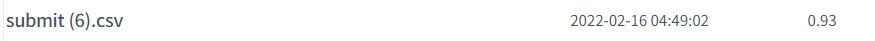